In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pyod

In [4]:
raw_data = pd.read_csv("../data/data4columbia_sales.csv")
raw_data

,symbol,period,period_start_dt,ptd_end_dt,reported_sales
0,ef1bcca724f3,2016Q4,2/29/2016,5/29/2016,1790.20
1,ef1bcca724f3,2017Q1,5/30/2016,8/28/2016,1714.40
2,ef1bcca724f3,2017Q2,8/29/2016,11/27/2016,1642.50
3,ef1bcca724f3,2017Q3,11/28/2016,2/26/2017,1878.70
4,ef1bcca724f3,2017Q4,2/27/2017,5/28/2017,1934.60
...,...,...,...,...,...
776,e2415cb7f63d,2021Q3,7/1/2021,9/30/2021,2594.96
777,e2415cb7f63d,2021Q4,10/1/2021,12/31/2021,2735.19
778,e2415cb7f63d,2022Q1,1/1/2022,3/31/2022,2542.00
779,e2415cb7f63d,2022Q2,4/1/2022,6/30/2022,2796.00


Let's not consider, for now, the period_start_dt and ptd_end_dt. This seems to be the specifics of when the quarter for that company started and ended. Let's see some general statistics about the sales by company, and for Wellington in general. First process the data to make period atomic.

In [5]:
type(raw_data.period[0])

str

In [6]:
years = raw_data.period.str.extract(r"(\d*)Q.*")
qs = raw_data.period.str.extract(r".*(Q.*)")
data = raw_data.loc[:, ["symbol", "reported_sales"]].assign(years = years).assign(quarters = qs)
data

,symbol,reported_sales,years,quarters
0,ef1bcca724f3,1790.20,2016,Q4
1,ef1bcca724f3,1714.40,2017,Q1
2,ef1bcca724f3,1642.50,2017,Q2
3,ef1bcca724f3,1878.70,2017,Q3
4,ef1bcca724f3,1934.60,2017,Q4
...,...,...,...,...
776,e2415cb7f63d,2594.96,2021,Q3
777,e2415cb7f63d,2735.19,2021,Q4
778,e2415cb7f63d,2542.00,2022,Q1
779,e2415cb7f63d,2796.00,2022,Q2


<h2> Grouped By Company </h2>


In [7]:
data_lengths = data.groupby(by="symbol").count()
data_lengths.head()

,reported_sales,years,quarters
symbol,,,
049fd91f3b99,25,25,25
07cdb4720792,17,17,17
0c228e9c216d,27,27,27
14df23d5c670,6,6,6
1bf8650b1b9b,19,19,19


In [8]:
companies = pd.unique(data.symbol)
companies, len(companies)

(array(['ef1bcca724f3', '22328d65a8ae', 'dfe2fbf1ed01', 'a4a7c48a5224',
        '7cc4ff7756ca', '8ded09ca1316', 'cf1f2a3136a8', 'c55bd78eb15c',
        'd8b9679fad55', 'b90599e97c3e', '9314b99e3365', 'c04e7e38a9e2',
        '8b8937c0ca2a', '8418d35f7b99', 'bb8b3ece0968', '695b1e497540',
        '1bf8650b1b9b', '5d0389d3507e', '5d32d7d55415', '07cdb4720792',
        '5cc1b4f7fbbd', 'be4cf0ff0e3c', '43b9e9b21999', '450c40bc1e47',
        'f726f3251b6d', '049fd91f3b99', '23f7ce412c07', 'd2ee94e6f008',
        'b691f62df5b8', '14df23d5c670', 'b0cc2d105808', 'fdfb7a6e49cf',
        '61bbe440bf3e', '8a5419583f31', '95d85d291db7', '0c228e9c216d',
        'e2415cb7f63d'], dtype=object),
 37)

<h3> Sales by Time </h3>

In [100]:
def sales_bytime(company):
    if company is None: 
        plot_data = data.loc[:,['reported_sales','years', 'quarters']].groupby(by=["years", "quarters"]).sum()
        plot_data = plot_data.reset_index()
        company=""
    else:
        plot_data = data.loc[data.symbol == company, ["years", "quarters", "reported_sales"]]
    fig = plt.gcf()
    x = range(0, len(plot_data))
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10, 5) 
    ax.plot(x, plot_data.reported_sales)
    labs = plot_data.years + " " + plot_data.quarters
    ax.set_xticks(x)
    ax.set_xticklabels(labs, rotation=45)
    ax.set_ylabel("Sales for Company: " + company)

<Figure size 640x480 with 0 Axes>

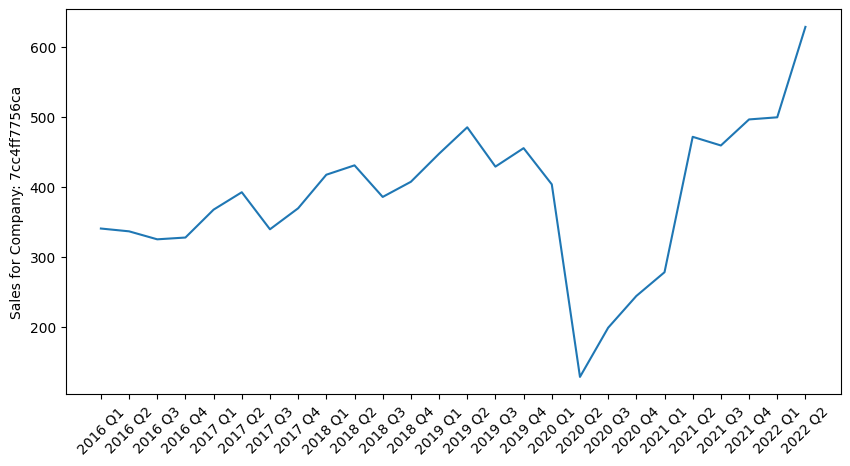

In [101]:
sales_bytime(companies[4]) #give any company name

<h3> Mean Sales by Year </h3>

In [102]:
def sales_ymean(company):
    plot_data = data.loc[data.symbol == company, ["years", "reported_sales"]].groupby("years").mean()
    fig = plt.gcf()
    x = range(0, len(plot_data))
    fig, ax = plt.subplots(1,1)
#     fig.set_size_inches(18.5, 10.5) 
    ax.bar(x, height = plot_data.reported_sales)
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data.index)
    ax.set_ylabel("Sales")
    plt.title("Annual Sales for Company: " + company)

<Figure size 640x480 with 0 Axes>

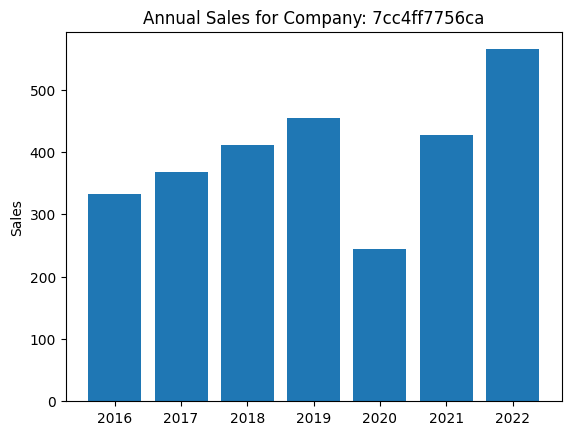

In [103]:
sales_ymean(companies[4])

In [104]:
def sales_boxplot(company):
    plot_data = data.loc[data.symbol == company, ["years", "reported_sales"]]
    ax = sns.boxplot(x = plot_data["reported_sales"])
    plt.title("Boxplot for Company Sales: " + company)

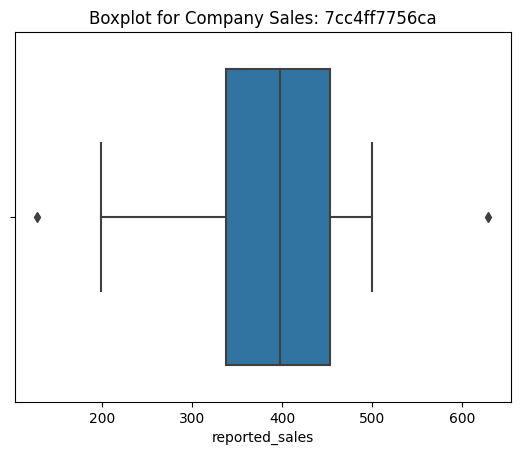

In [105]:
sales_boxplot(companies[4])

In [106]:
def sales_acf(company):
    plot_data = data.loc[data.symbol == company, ["years", "reported_sales"]]
    sm.graphics.tsa.plot_acf(
            plot_data['reported_sales'], title="Autocorrelation Plot of Company Sales: "+company)

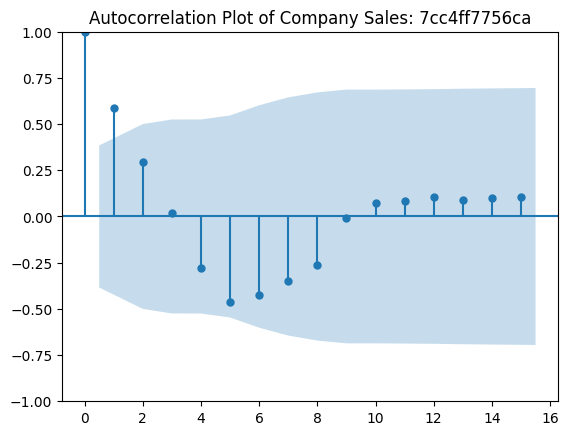

In [107]:
sales_acf(companies[4])

In [108]:
def sales_hist(company):
    plot_data = data.loc[data.symbol == company, "reported_sales"]

    data_mean, data_std = plot_data.mean(), plot_data.std()
    cut_off = data_std * 1
    lower, upper = data_mean - cut_off, data_mean + cut_off

    sns.displot(plot_data, bins=30, kde=True)
    plt.axvspan(xmin=lower, xmax=plot_data.min(), alpha=0.2, color='red')
    plt.axvspan(xmin=upper, xmax=plot_data.max(), alpha=0.2, color='red')
    plt.title("Histogram for Company Sales: " + company)

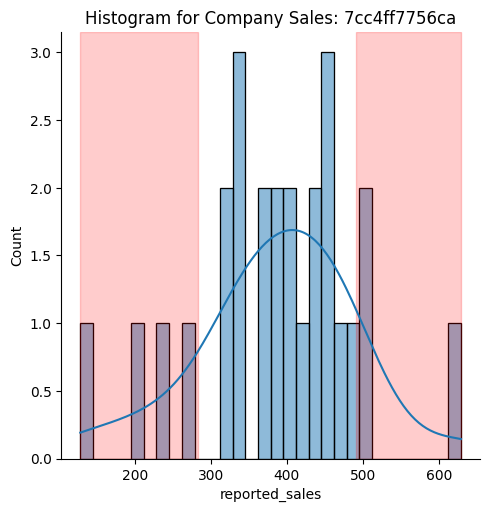

In [109]:
sales_hist(companies[4])

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [135]:
def sales_stl(company):
    period = 7
    plot_data = data.loc[data.symbol == company, ["reported_sales"]]
    stlResults = seasonal_decompose(plot_data, period=period)
    fig = stlResults.plot()
    fig.set_size_inches(5, 10) 

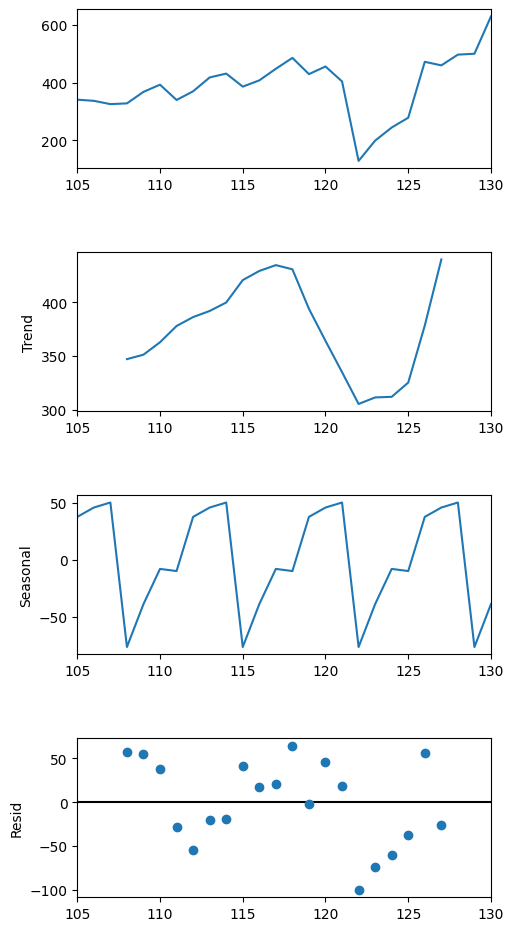

In [136]:
sales_stl(companies[4])

From https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

In [112]:
from sklearn.ensemble import IsolationForest

In [113]:
def isol_forest(company):
    isolation_forest = IsolationForest(n_estimators=100)
    plot_data = data.loc[data.symbol == company, ["reported_sales"]]

    isolation_forest.fit(plot_data['reported_sales'].values.reshape(-1, 1))
    xx = np.linspace(plot_data['reported_sales'].min(), plot_data['reported_sales'].max(), len(plot_data))\
    .reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    plt.figure(figsize=(6,4))
    plt.plot(xx, anomaly_score, label='anomaly score')
    plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    plt.legend()
    plt.ylabel('anomaly score')
    plt.xlabel('Sales')
    plt.show()

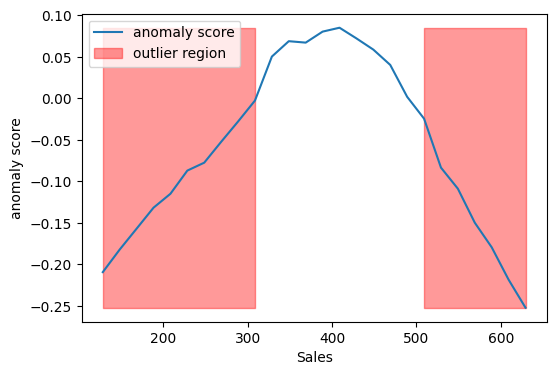

In [114]:
isol_forest(companies[4])

<h2> Wellington General EDA </h2>

In [123]:
def gross_sales():
    plot_data = data.loc[:,['reported_sales','years', 'quarters']].groupby(by=["years", "quarters"]).sum()
    plot_data = plot_data.reset_index()
    fig = plt.gcf()
    x = range(0, len(plot_data))
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10, 5) 
    ax.plot(x, plot_data.reported_sales)
    labs = plot_data.years + " " + plot_data.quarters
    ax.set_xticks(x)
    ax.set_xticklabels(labs, rotation=45)
    ax.set_ylabel("Gross Sales")

<Figure size 640x480 with 0 Axes>

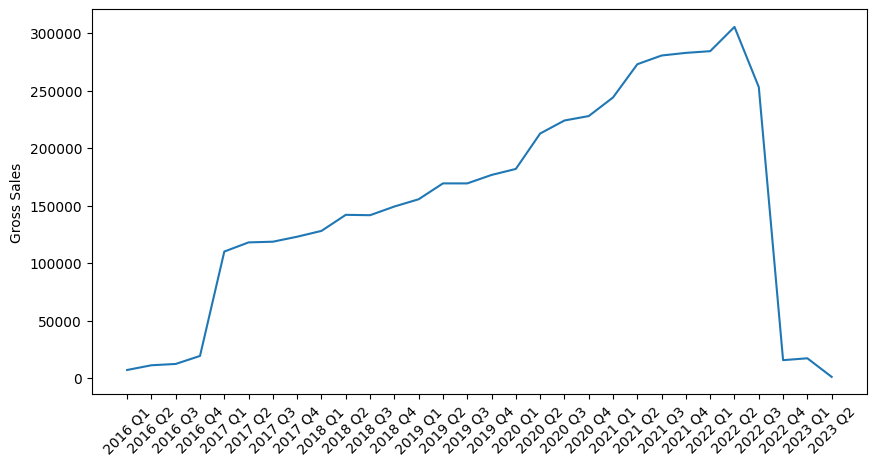

In [124]:
gross_sales()

In [125]:
gross = data.loc[:,['reported_sales','years', 'quarters']].groupby(by=["years", "quarters"]).sum()
gross = gross.reset_index()
gross.head()

,years,quarters,reported_sales
0,2016,Q1,6939.837901
1,2016,Q2,11045.226325
2,2016,Q3,12190.314988
3,2016,Q4,19170.405348
4,2017,Q1,110009.353500


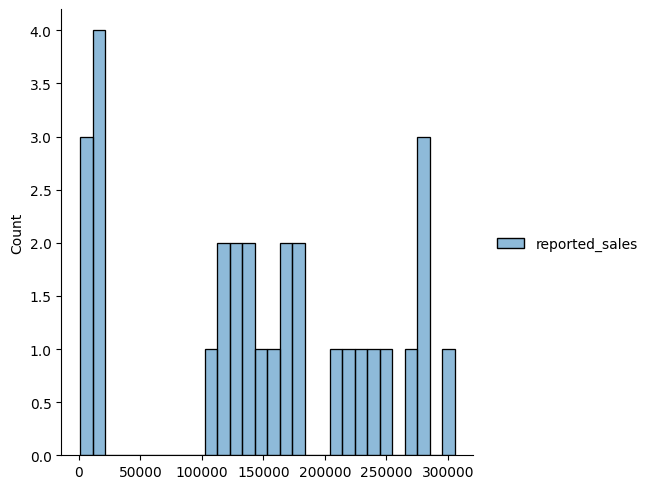

In [126]:
sns.displot(gross, bins=30)

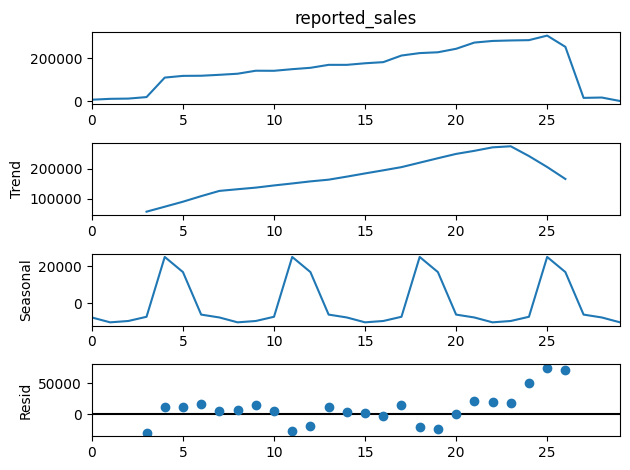

In [134]:
period=7
stlResults = seasonal_decompose(gross.reported_sales, period=period)
stlResults.plot()
pass